In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
from nanonets import Simulation
from matplotlib.colors import Normalize
from scipy.optimize import curve_fit
from scipy.special import gamma
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d

plt.style.use(["science","bright","grid"])

V_WRITES    = [0.025,0.03,0.035,0.04]
T_WRITES    = [0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2]
T_WAITS     = [0.0,0.1,0.15,0.2,0.3,0.5,0.7,1.,1.5,2.,3.,5.,7.,10.,15.,20.,30.,50.,70.,100.,150.,200.,300.,500.,700.,1000.]
N_VOLT      = 50000
TIME_STEP   = 1.5e-11
CMAP        = plt.get_cmap('cividis')
FOLDER      = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/DC/two_steps/"
# FOLDER      = "/home/j/j_mens07/phd/data/2_funding_period/dynamic/DC/two_steps/"
# FOLDER      = "/home/j/j_mens07/bagheera/data/2_funding_period/dynamic/DC/two_steps/"
N_PARTICLES = 9
ELE_AC      = 0.160217662

def lin_func(x, a, b, c):
    return a*(x-b) + c
def stretched_exp(t, tau, beta, I0):
    return I0*np.exp(-(t/tau)**beta)
def exp_decay(t, tau, A):
    return 1 + A*np.exp(-t/tau)
topo = {"Nx": N_PARTICLES,"Ny": N_PARTICLES,
        "e_pos": [[(N_PARTICLES-1)//2, 0],[0, 0],[N_PARTICLES-1, 0],
                [0, (N_PARTICLES-1)//2],[N_PARTICLES-1, (N_PARTICLES-1)//2],
                [0, N_PARTICLES-1],[N_PARTICLES-1, N_PARTICLES-1],[(N_PARTICLES-1)//2, N_PARTICLES-1]],
        "electrode_type": ['constant']*8}
sim_class = Simulation(topo)
cap_mat   = sim_class.get_capacitance_matrix()
cap_mat_e = sim_class.get_electrode_capacitance_matrix()

In [2]:
def paired_pulse(V_write, t_write, t_wait, dt, N_electrodes=8, input_pos=0):
    
    # 1. Convert times to integer number of steps (force symmetry)
    # Using round() ensures we grab the nearest valid step count
    n_write = int(np.round(t_write / dt))
    n_wait  = int(np.round(t_wait / dt))
    
    # 2. Total simulation length
    # Note: We enforce the second pulse is exactly n_write long
    n_total = n_write + n_wait + n_write 
    
    # 3. Create Time Series
    t_series = np.arange(0, n_total+1) * dt
    
    # 4. Create Voltage Vector (default 0)
    V_signal = np.zeros(n_total)
    
    # 5. Assign Pulse 1 (Indices 0 to n_write)
    V_signal[0 : n_write] = V_write
    
    # 6. Assign Pulse 2 (Indices start after wait)
    # Start: n_write + n_wait
    # End:   n_write + n_wait + n_write
    start_2 = n_write + n_wait
    end_2   = start_2 + n_write
    V_signal[start_2 : end_2] = V_write

    # 7. Map to Electrodes
    voltages = np.zeros((n_total, N_electrodes+1))
    voltages[:, input_pos] = V_signal

    return t_series, voltages

### Load from Cluster

In [6]:
t   = {V : {t : [paired_pulse(V, t*1e-9, tw*1e-9, TIME_STEP)[0][:]*1e9 for tw in T_WAITS] for t in T_WRITES} for V in V_WRITES}
x   = {V : {t : [paired_pulse(V, t*1e-9, tw*1e-9, TIME_STEP)[1][:,0]*1000 for tw in T_WAITS] for t in T_WRITES} for V in V_WRITES}
q   = {V : {t : [pd.read_csv(f"{FOLDER}mean_state_Nx={N_PARTICLES}_Ny={N_PARTICLES}_Ne=8_{V:.5f}_{t:.5f}_{tw:.5f}.csv").values for tw in T_WAITS] for t in T_WRITES} for V in V_WRITES}
y   = {V : {t : [pd.read_csv(f"{FOLDER}Nx={N_PARTICLES}_Ny={N_PARTICLES}_Ne=8_{V:.5f}_{t:.5f}_{tw:.5f}.csv")['Observable'].values*1e-6 for tw in T_WAITS] for t in T_WRITES} for V in V_WRITES}
y_e = {V : {t : [pd.read_csv(f"{FOLDER}Nx={N_PARTICLES}_Ny={N_PARTICLES}_Ne=8_{V:.5f}_{t:.5f}_{tw:.5f}.csv")['Error'].values*1e-6 for tw in T_WAITS] for t in T_WRITES} for V in V_WRITES}

In [18]:
for V in V_WRITES:
    for t in T_WRITES:
        for i in range(len(T_WAITS)):
            np.save(f"data/two_step/N_{N_PARTICLES}_q_{T_WAITS[i]:.5f}_{t:.5f}_{V:.5f}.npy", q[V][t][i])
            np.save(f"data/two_step/N_{N_PARTICLES}_y_{T_WAITS[i]:.5f}_{t:.5f}_{V:.5f}.npy", y[V][t][i])
            np.save(f"data/two_step/N_{N_PARTICLES}_y_e_{T_WAITS[i]:.5f}_{t:.5f}_{V:.5f}.npy", y_e[V][t][i])

### Load from Local

In [238]:
N_PARTICLES = 7
t   = {V : {t : [paired_pulse(V, t*1e-9, tw*1e-9, TIME_STEP)[0][:]*1e9 for tw in T_WAITS] for t in T_WRITES} for V in V_WRITES}
x   = {V : {t : [paired_pulse(V, t*1e-9, tw*1e-9, TIME_STEP)[1][:,0]*1000 for tw in T_WAITS] for t in T_WRITES} for V in V_WRITES}
q   = {V : {t : [np.load(f"data/two_step/N_{N_PARTICLES}_q_{T_WAITS[i]:.5f}_{t:.5f}_{V:.5f}.npy") for i in range(len(T_WAITS))] for t in T_WRITES} for V in V_WRITES}
y   = {V : {t : [np.load(f"data/two_step/N_{N_PARTICLES}_y_{T_WAITS[i]:.5f}_{t:.5f}_{V:.5f}.npy") for i in range(len(T_WAITS))] for t in T_WRITES} for V in V_WRITES}
y_e = {V : {t : [np.load(f"data/two_step/N_{N_PARTICLES}_y_e_{T_WAITS[i]:.5f}_{t:.5f}_{V:.5f}.npy") for i in range(len(T_WAITS))] for t in T_WRITES} for V in V_WRITES}

### Time Constants
- Autocorrelation: 28 ns
- Relaxation: 5 - 10 ns (10-40 bias)

### State-based

In [10]:
ppr_q       = {}
r_decay_q   = {}
for n, v_write in enumerate(V_WRITES):
    ppr2 = {}
    r_decay2 = {}
    for m, t_write in enumerate(T_WRITES):
        lt = []
        lt2 = []
        for i, t_wait in enumerate(T_WAITS):
            # Charge Offset [aC]
            offset  = sim_class.get_charge_vector_offset(np.array([v_write,0,0,0,0,0,0,0,0]))

            # Pot values [V]
            x_vals  = x[v_write][t_write][i].copy()
            q_vals  = q[v_write][t_write][i].copy()[:,8:]
            q_vals  = np.vstack((np.zeros(N_PARTICLES**2),q_vals))

            # Pulse Index
            idx_w   = np.where(x_vals == 0.0)[0]
            if len(idx_w) != 0:
                t1_end  = idx_w[0] - 1
                t2_sta  = idx_w[-1] + 1
            else:
                t1_end  = len(x_vals)//2 - 1
                t2_sta  = len(x_vals)//2

            # Charge vector at start-end-start-end @ pulse
            q0  = cap_mat @ q_vals.copy()[0,] #- offset
            q1  = cap_mat @ q_vals.copy()[t1_end,:] #- offset
            q2  = cap_mat @ q_vals.copy()[t2_sta,:] #- offset
            q3  = cap_mat @ q_vals.copy()[-1,:] #- offset

            # Paired-Pulse-Index            
            R1  = np.linalg.norm(q1 - q0)
            R2  = np.linalg.norm(q3 - q2)
            RV  = (R2 - R1) / (R2 + R1)
            lt.append(RV)

            # Charge vector at start-end @ wait
            qw1 = cap_mat @ q_vals.copy()[t1_end+1,:]
            qw2 = cap_mat @ q_vals.copy()[t2_sta-1,:]
            Rw  = np.linalg.norm(qw2 - qw1)
            Rd  = (R1 - Rw) / (R1 + Rw)
            lt2.append(Rd)
            
        ppr2[t_write] = lt
        r_decay2[t_write] = lt2
        
    ppr_q[v_write] = ppr2
    r_decay_q[v_write] = r_decay2

ppr_I     = {}
r_decay_I = {}
for n, v_write in enumerate(V_WRITES):
    ppr2 = {}
    r_decay2 = {}
    for m, t_write in enumerate(T_WRITES):
        lt = []
        lt2 = []
        for i, t_wait in enumerate(T_WAITS):

            # Current values [pA]
            t_vals  = t[v_write][t_write][i].copy()[1:]
            x_vals  = x[v_write][t_write][i].copy()
            I_vals  = y[v_write][t_write][i].copy()
            # I_vals  = np.hstack((0.0,I_vals))

            # Pulse Index
            idx_w   = np.where(x_vals == 0.0)[0]
            if len(idx_w) != 0:
                t1_end  = idx_w[0]
                t2_sta  = idx_w[-1] + 1
            else:
                t1_end  = len(x_vals)//2 - 1
                t2_sta  = len(x_vals)//2
            

            I_1 = I_vals[:t1_end]
            t1  = t_vals[:t1_end]
            I_2 = I_vals[t2_sta:]
            t2  = t_vals[t2_sta:]
            # Paired-Pulse-Index            
            R1  = np.trapezoid(y=I_1, x=t1)
            R2  = np.trapezoid(y=I_2, x=t2)
            RV  = (R2 - R1) / (R2 + R1)
            lt.append(RV)

            # Charge vector at start-end @ wait
            I_w = I_vals[t1_end:t2_sta]
            tw  = t_vals[t1_end:t2_sta]
            Rw  = np.trapezoid(y=I_w, x=tw)
            Rd  = (R1 - Rw) / (R1 + Rw)
            lt2.append(Rd)
            
        ppr2[t_write] = lt
        r_decay2[t_write] = lt2
        
    ppr_I[v_write] = ppr2
    r_decay_I[v_write] = r_decay2

TypeError: 'float' object is not subscriptable

### State Forgetting Curve

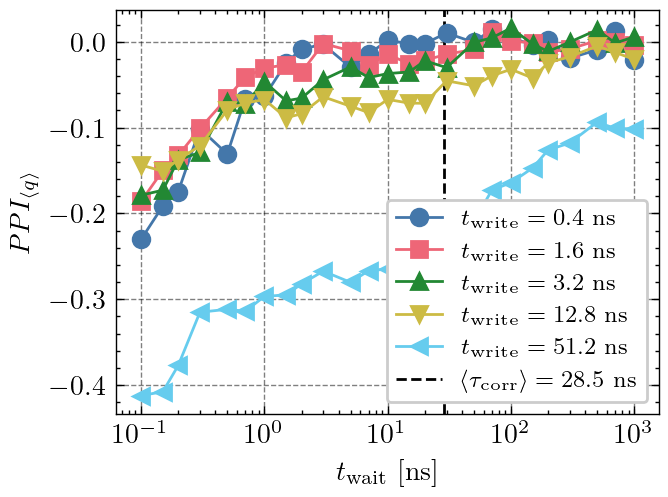

In [12]:
T_W_VAL = [0.4,1.6,3.2,12.8,51.2]
markers = ['o','s','^','v','<','>']
fig, ax = plt.subplots(dpi=200)
v_write = 0.04
for i, t_write in enumerate(T_W_VAL):
    x_plot  = np.array(T_WAITS).copy()[1:]
    y_plot  = np.array(ppr_q[v_write][t_write]).copy()[1:]
    ax.plot(x_plot, y_plot, label="$t_\\textrm{write}"+f" = {t_write}$ ns", ls='-', marker=markers[i])
_   = plt.axvline(28.5, label="$\\langle\\tau_\\textrm{corr}\\rangle = 28.5~\mathrm{ns}$", color='black', ls='--', zorder=0.1)
_   = ax.set_xscale('log')
_   = ax.legend(fontsize='small', ncol=1, loc='lower right')#, title=f'$U_w = {1000*v_write}$ mV', title_fontsize='small')
_   = ax.set_ylabel("$PPI_{\\langle q \\rangle}$")
_   = ax.set_xlabel("$t_\\textrm{wait}$ [ns]")

# fig.savefig(f"plots/png/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPI_q_vs_t_wait_{v_write}.png", transparent=False)
# fig.savefig(f"plots/pdf/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPI_q_vs_t_wait_{v_write}.pdf", transparent=False)
# fig.savefig(f"plots/svg/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPI_q_vs_t_wait_{v_write}.svg", transparent=True)

### Output Forgetting Curve

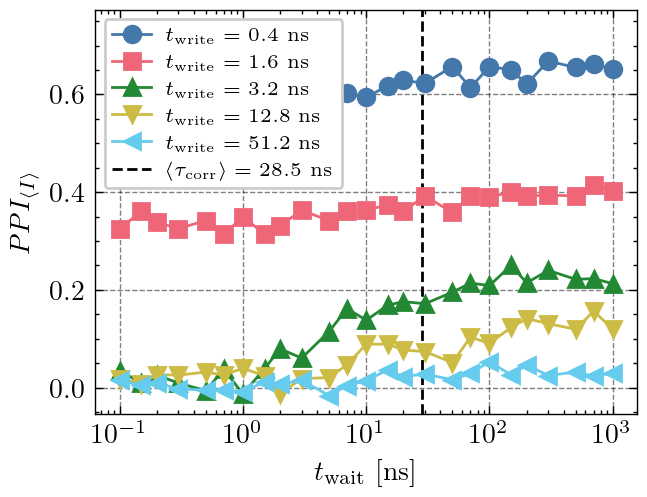

In [239]:
T_W_VAL = [0.4,1.6,3.2,12.8,51.2]
markers = ['o','s','^','v','<','>']
fig, ax = plt.subplots(dpi=200)
v_write = 0.04
for i, t_write in enumerate(T_W_VAL):
    x_plot  = np.array(T_WAITS).copy()[1:]
    y_plot  = np.array(ppr_I[v_write][t_write]).copy()[1:]
    ax.plot(x_plot, y_plot, label="$t_\\textrm{write}"+f" = {t_write}$ ns", ls='-', marker=markers[i])
_   = plt.axvline(28.5, label="$\\langle\\tau_\\textrm{corr}\\rangle = 28.5~\mathrm{ns}$", color='black', ls='--', zorder=0.1)
_   = ax.set_xscale('log')
# _   = ax.set_ylim(0,1.1)
# _   = ax.set_ylim(-1,0.1)
_   = ax.legend(fontsize='x-small', ncol=1, loc='upper left')
_   = ax.set_ylabel("$PPI_{\\langle I \\rangle}$")
_   = ax.set_xlabel("$t_\\textrm{wait}$ [ns]")

fig.savefig(f"plots/png/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPI_I_vs_t_wait_{v_write}.png", transparent=False)
fig.savefig(f"plots/pdf/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPI_I_vs_t_wait_{v_write}.pdf", transparent=False)
fig.savefig(f"plots/svg/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPI_I_vs_t_wait_{v_write}.svg", transparent=True)

### Writing Curve

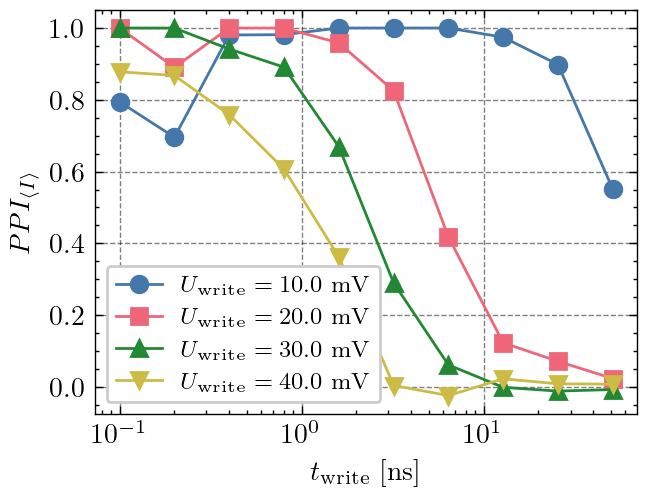

In [240]:
markers = ['o','s','^','v','<','>']
fig, ax = plt.subplots(dpi=200)
t_w_i   = 0
for i, v_write in enumerate(V_WRITES):
    x_plot  = np.array(T_WRITES).copy()
    y_plot  = np.array([ppr_I[v_write][t_write][t_w_i] for t_write in T_WRITES]).copy()
    ax.plot(x_plot, y_plot, label="$U_\\textrm{write}"+f" = {v_write*1000}$ mV", ls='-', marker=markers[i])
# _   = plt.axvline(28.5, label="$\\langle\\tau_\\textrm{corr}\\rangle$", color='black', ls='--', zorder=0.1)
_   = ax.set_xscale('log')
# _   = ax.set_ylim(-1,0.)
_   = ax.legend(fontsize='small', ncol=1, loc='lower left')#, title=f'$U_w = {1000*v_write}$ mV', title_fontsize='small')
_   = ax.set_ylabel("$PPI_{\\langle I \\rangle}$")
_   = ax.set_xlabel("$t_\\textrm{write}$ [ns]")

fig.savefig(f"plots/png/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPI_I_vs_t_write_{T_WRITES[t_w_i]}.png", transparent=False)
fig.savefig(f"plots/pdf/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPI_I_vs_t_write_{T_WRITES[t_w_i]}.pdf", transparent=False)
fig.savefig(f"plots/svg/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPI_I_vs_t_write_{T_WRITES[t_w_i]}.svg", transparent=True)

ValueError: array must not contain infs or NaNs

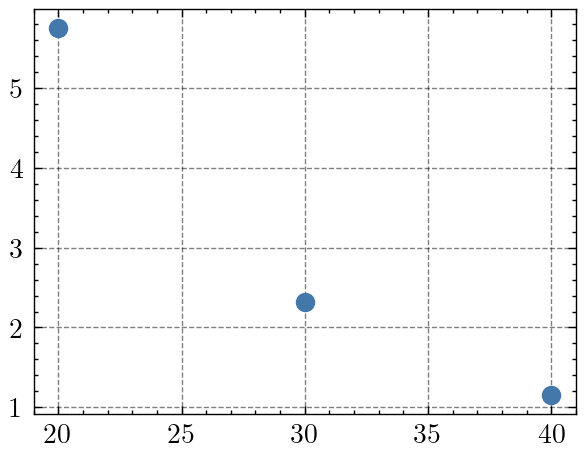

In [241]:
def get_t_crit(t_write_vals, ppi_curve, threshold=0.5):
    # 1. Create an interpolator function (f(t) = PPI)
    # We use linear interpolation between your discrete points
    # We flip the arrays because interp1d needs x to be strictly increasing
    f = interp1d(t_write_vals, ppi_curve, kind='linear')
    
    # 2. Find where it crosses 0.5
    # Since we want t where f(t)=0.5, and the function is monotonic decreasing,
    # we can just sweep or use a root finder. 
    # A simpler hack for monotonic data: interpolate the INVERSE function.
    
    # Safety: ensure curve actually crosses the threshold
    if np.min(ppi_curve) > threshold or np.max(ppi_curve) < threshold:
        return np.nan # Threshold not reached in this window
        
    f_inv = interp1d(ppi_curve, t_write_vals, kind='linear')
    
    return float(f_inv(threshold))

t_crits = []
start   = 3
for i, v_write in enumerate(V_WRITES):
    x_plot  = np.array(T_WRITES).copy()
    y_plot  = np.array([ppr_I[v_write][t_write][t_w_i] for t_write in T_WRITES]).copy()
    t_crit  = get_t_crit(x_plot[start:], y_plot[start:])
    t_crits.append(t_crit)

def one_over_V(x, a, b):
    return a*x**b

V_PLOT  = np.linspace(V_WRITES[0], V_WRITES[-1], 100)*1000
fig, ax = plt.subplots(dpi=200)
pp      = ax.plot(np.array(V_WRITES)*1000, t_crits, 'o')
popt, _ = curve_fit(one_over_V, np.array(V_WRITES)*1000, t_crits)
_       = ax.plot(V_PLOT, one_over_V(V_PLOT,*popt), '-', color=pp[0].get_color(),
                  label='$t_\\textrm{crit} \propto U_\\textrm{write}^'+'{'+f'{np.round(popt[1],2)}'+'}$')
# _       = ax.set_xscale('log')
# _       = ax.set_yscale('log')
_       = ax.legend()
_       = ax.set_xlabel('$U_\\textrm{write}$ [mV]')
_       = ax.set_ylabel("$t_\\textrm{crit}$ [ns]")

fig.savefig(f"plots/png/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_t_crit_vs_U_write.png", transparent=False)
fig.savefig(f"plots/pdf/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_t_crit_vs_U_write.pdf", transparent=False)
fig.savefig(f"plots/svg/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_t_crit_vs_U_write.svg", transparent=True)

### Correlation Plot

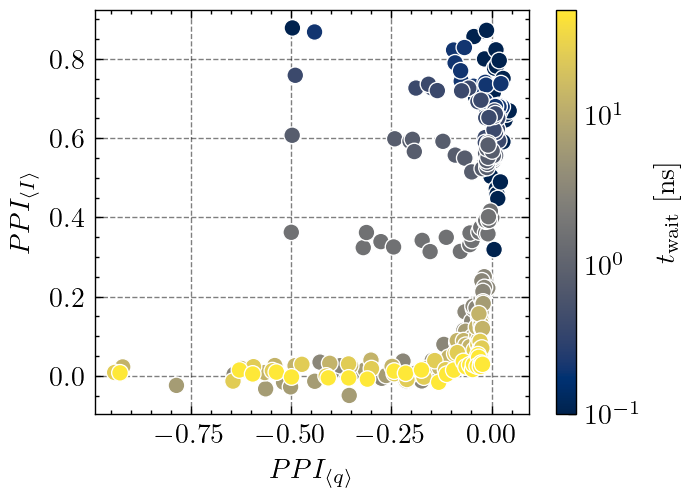

In [234]:
u_write             = 0.04
ppr_all             = pd.DataFrame(ppr_q[u_write]).melt(var_name='t_write', value_name='ppr_q')
df2                 = pd.DataFrame(ppr_I[u_write]).melt(var_name='t_write', value_name='ppr_I')
ppr_all['ppr_I']    = df2['ppr_I']

fig, ax = plt.subplots(dpi=200)
ax      = sns.scatterplot(ppr_all, x='ppr_q', y='ppr_I', hue='t_write', palette='cividis', hue_norm=LogNorm(), legend=False)
norm    = LogNorm(vmin=ppr_all['t_write'].min(), vmax=ppr_all['t_write'].max())
sm      = plt.cm.ScalarMappable(cmap='cividis', norm=norm)
sm.set_array([])
_       = plt.colorbar(sm, ax=ax, label='$t_\\textrm{wait}$ [ns]')
_       = ax.set_xlabel("$PPI_{\\langle q \\rangle}$")
_       = ax.set_ylabel("$PPI_{\\langle I \\rangle}$")
# _       = ax.set_xlim(-1,0.15)
# _       = ax.set_ylim(-0.15,1.0)

fig.savefig(f"plots/png/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPI_I_vs_PPI_q_{v_write}.png", transparent=False)
fig.savefig(f"plots/pdf/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPI_I_vs_PPI_q_{v_write}.pdf", transparent=False)
fig.savefig(f"plots/svg/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPI_I_vs_PPI_q_{v_write}.svg", transparent=True)

### Bandwidth

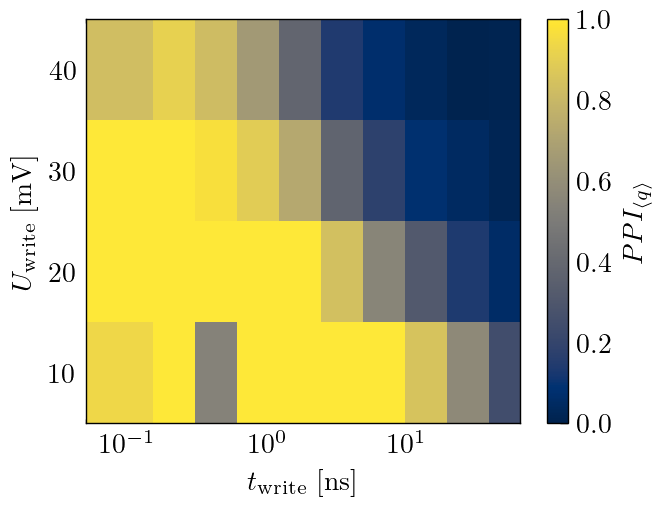

In [175]:
fig, ax = plt.subplots(dpi=200)
mesh    = ax.pcolormesh(T_WRITES, np.array(V_WRITES)*1000, np.array([[ppr_I[u][tw][0] for tw in T_WRITES] for u in V_WRITES]),
                        cmap='cividis', shading='nearest', vmin=0, vmax=1)
_       = ax.set_xscale('log')
_       = ax.set_xlabel('$t_\\textrm{write}$ [ns]')
_       = ax.set_ylabel('$U_\\textrm{write}$ [mV]')
cb      = plt.colorbar(mesh, ax=ax, label="$PPI_{\\langle q \\rangle}$")

fig.savefig(f"plots/png/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPI_I_vs_t_write_and_U_write.png", transparent=False)
fig.savefig(f"plots/pdf/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPI_I_vs_t_write_and_U_write.pdf", transparent=False)
fig.savefig(f"plots/svg/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPI_I_vs_t_write_and_U_write.svg", transparent=True)

### I(t) Trace

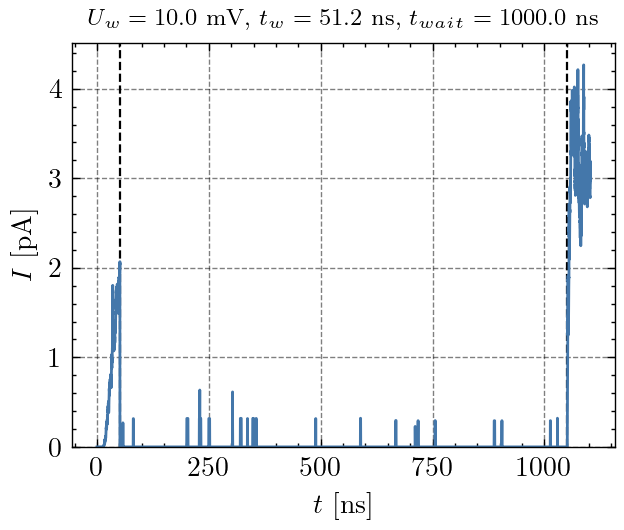

In [230]:
v_write = 0.01
t_write = 51.2
idx     = 25
x_vals  = x[v_write][t_write][idx]
t_vals  = t[v_write][t_write][idx]
tw1     = np.where(x_vals==0)[0][0]-1
tw2     = np.where(x_vals==0)[0][-1]+1

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
_   = ax.plot(t_vals[:-1], y[v_write][t_write][idx])
_   = ax.set_xlabel("$t$ [ns]")
_   = ax.set_ylabel("$I$ [pA]")
_   = ax.set_title(f'$U_w = {v_write*1000}$ mV, $t_w = {t_write}$ ns, '+'$t_{wait} = '+f'{T_WAITS[idx]}$ ns', fontsize='small')
# _   = ax.set_yscale('log')
_   = ax.set_ylim(0)
_   = plt.axvline(t_vals[tw1], color='black', ls='--', zorder=0.1, lw=0.8)
_   = plt.axvline(t_vals[tw2], color='black', ls='--', zorder=0.1, lw=0.8)

# fig.savefig(f"plots/png/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_out_response_Uw={v_write}_tw={t_write}_twa={T_WAITS[idx]}.png", transparent=False)
# fig.savefig(f"plots/pdf/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_out_response_Uw={v_write}_tw={t_write}_twa={T_WAITS[idx]}.pdf", transparent=False)
# fig.savefig(f"plots/svg/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_out_response_Uw={v_write}_tw={t_write}_twa={T_WAITS[idx]}.svg", transparent=True)

---

### Writing Efficiency

In [ ]:
markers = ['o','s','^','v','<','>']
fig, ax = plt.subplots(dpi=200)
t_w_i   = 0
for i, v_write in enumerate(V_WRITES):
    x_plot  = np.array(T_WRITES).copy()
    y_plot  = np.array([ppr_q[v_write][t_write][t_w_i] for t_write in T_WRITES]).copy()
    ax.plot(x_plot, y_plot, label="$U_\\textrm{write}"+f" = {v_write*1000}$ mV", ls='-', marker=markers[i])
# _   = plt.axvline(28.5, label="$\\langle\\tau_\\textrm{corr}\\rangle$", color='black', ls='--', zorder=0.1)
_   = ax.set_xscale('log')
# _   = ax.set_ylim(-1,0.)
_   = ax.legend(fontsize='small', ncol=1, loc='lower left')#, title=f'$U_w = {1000*v_write}$ mV', title_fontsize='small')
_   = ax.set_ylabel("$PPI_{\\langle q \\rangle}$")
_   = ax.set_xlabel("$t_\\textrm{write}$ [ns]")

fig.savefig(f"plots/png/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPI_q_vs_t_write_{T_WRITES[t_w_i]}_q.png", transparent=False)
fig.savefig(f"plots/pdf/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPI_q_vs_t_write_{T_WRITES[t_w_i]}.pdf", transparent=False)
fig.savefig(f"plots/svg/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPI_q_vs_t_write_{T_WRITES[t_w_i]}.svg", transparent=True)

In [ ]:
T_W_VAL = [0.1,0.4,1.6,3.2,12.8,51.2]
markers = ['o','s','^','v','<','>']
fig, ax = plt.subplots(dpi=200)
v_write = 0.04
for i, t_write in enumerate(T_W_VAL):
    x_plot  = np.array(T_WAITS).copy()
    y_plot  = np.array(r_decay_q[v_write][t_write]).copy()
    ax.plot(x_plot, y_plot, label="$t_\\textrm{write}"+f" = {t_write}$ ns", ls='-', marker=markers[i])
_   = plt.axvline(28.5, label="$\\langle\\tau_\\textrm{corr}\\rangle$", color='black', ls='--', zorder=0.1)
_   = ax.set_xscale('log')
_   = ax.set_ylim(-0.1,1.0)
_   = ax.legend(fontsize='small', ncol=1, loc='upper right')#, title=f'$U_w = {1000*v_write}$ mV', title_fontsize='small')
_   = ax.set_ylabel("$R_{retained}$")
_   = ax.set_xlabel("$t_\\textrm{wait}$ [ns]")

# fig.savefig(f"plots/png/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPR_vs_t_wait_{v_write}_q.png", transparent=False)
# fig.savefig(f"plots/pdf/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPR_vs_t_wait_{v_write}.pdf", transparent=False)
# fig.savefig(f"plots/svg/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPR_vs_t_wait_{v_write}.svg", transparent=True)

### Memory Landscape

In [ ]:
v_write = 0.01
fig, ax = plt.subplots(dpi=200)
mesh    = ax.pcolormesh(T_WAITS, T_WRITES, np.array([ppr_q[v_write][t1] for t1 in T_WRITES]), vmin=-1, vmax=1, cmap='coolwarm', shading='nearest')
cb      = plt.colorbar(mesh, ax=ax, label="$PPI_{\\langle q \\rangle}$")
_       = ax.set_xscale('log')
_       = ax.set_yscale('log')
_       = ax.set_xlabel("$t_\\textrm{wait}$ [ns]")
_       = ax.set_ylabel("$t_\\textrm{write}$ [ns]")

fig.savefig(f"plots/png/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPI_q_map_{v_write}_q.png", transparent=False)
fig.savefig(f"plots/pdf/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPI_q_map_{v_write}.pdf", transparent=False)
fig.savefig(f"plots/svg/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPI_q_map_{v_write}.svg", transparent=True)

### Current based

In [ ]:
v_write = 0.04
fig, ax = plt.subplots(dpi=200)
mesh    = ax.pcolormesh(T_WAITS, T_WRITES, np.array([ppr_I[v_write][t1] for t1 in T_WRITES]), vmin=-1, vmax=1, cmap='coolwarm', shading='nearest')
cb      = plt.colorbar(mesh, ax=ax, label="$PPI_{\\langle q \\rangle}$")
_       = ax.set_xscale('log')
_       = ax.set_yscale('log')
_       = ax.set_xlabel("$t_\\textrm{wait}$ [ns]")
_       = ax.set_ylabel("$t_\\textrm{write}$ [ns]")

# fig.savefig(f"plots/png/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPI_q_map_{v_write}_q.png", transparent=False)
# fig.savefig(f"plots/pdf/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPI_q_map_{v_write}.pdf", transparent=False)
# fig.savefig(f"plots/svg/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPI_q_map_{v_write}.svg", transparent=True)

In [ ]:
T_W_VAL = [0.1,0.4,1.6,3.2,12.8,51.2]
markers = ['o','s','^','v','<','>']
fig, ax = plt.subplots(dpi=200)
v_write = 0.04
for i, t_write in enumerate(T_W_VAL):
    x_plot  = np.array(T_WAITS).copy()
    y_plot  = np.array(r_decay[v_write][t_write]).copy()
    ax.plot(x_plot, y_plot, label="$t_\\textrm{write}"+f" = {t_write}$ ns", ls='-', marker=markers[i])
_   = plt.axvline(28.5, label="$\\langle\\tau_\\textrm{corr}\\rangle$", color='black', ls='--', zorder=0.1)
_   = ax.set_xscale('log')
_   = ax.set_ylim(-0.1,1.0)
_   = ax.legend(fontsize='small', ncol=1, loc='upper right')#, title=f'$U_w = {1000*v_write}$ mV', title_fontsize='small')
_   = ax.set_ylabel("$R_{retained}$")
_   = ax.set_xlabel("$t_\\textrm{wait}$ [ns]")

# fig.savefig(f"plots/png/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPR_vs_t_wait_{v_write}_q.png", transparent=False)
# fig.savefig(f"plots/pdf/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPR_vs_t_wait_{v_write}.pdf", transparent=False)
# fig.savefig(f"plots/svg/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPR_vs_t_wait_{v_write}.svg", transparent=True)